In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, σ: float, dim: int, n: int, seed: int, use_AV: bool = False):
        """ Class for pricing American Options using LSM. 
        
        Parameters: 
        r (float): Risk-free interest rate
        S0 (float): Initial asset value
        K (float): Strike price
        T (float): Time to maturity, in years
        σ (float): Volatility coefficient for diffusion
        dim (int): Number of paths to simulate
        n (int): Number of time steps between time 0 and time T
        seed (int): Random seed for reproducibility
        use_AV (bool): Flag to use Antithetic Variates method (default: False)
        """
        
        assert σ >= 0, 'Volatility cannot be less than zero'
        assert S0 >= 0, 'Initial stock price cannot be less than zero'
        assert T >= 0, 'Time to maturity cannot be less than zero'
        assert n >= 0, 'Number of slices per year cannot be less than zero'
        assert dim >= 0, 'Number of simulation paths cannot be less than zero'
        
        # Set the random seed for reproducibility
        np.random.seed(seed)
        
        self.r = r
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.n = n
        self.Δ = self.T / self.n
        self.df = np.exp(-self.r * self.Δ)
        self.use_AV = use_AV
        self.dim = dim

        if use_AV:
            assert dim % 2 == 0, 'For AV, the number of paths (dim) must be even'
            half_dim = dim // 2
            Z_half = np.random.normal(0, 1, (half_dim, self.n - 1)) #Z_half matrix with dimension (half_dim, self.n-1), representing random increments of the asset´s price over time for half the paths'
            self.Z = np.concatenate((Z_half, -Z_half), axis=0)  # Antithetic variates. Creating full matrix self:Z by concatenating Z_half with its negation -Z.half.
        else:
            self.Z = np.random.normal(0, 1, (dim, self.n - 1))  # Original method

        self.S = np.full((dim, self.n), np.nan)  # Allocate space for stock price process

    def GeometricBrownianMotion(self):
        """ Generate GBM paths according to Algorithm 3.
        
        Returns:
        np.ndarray: Simulated paths of the asset price.
        """
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        
        S[:,0] = np.log(S0)  # Set initial values
        for j in range(1,n):
            S[:,j] = S[:,j-1] + (r-0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z[:,j-1]
            
        self.S = np.exp(S)  # Exponentiate to get the GBM paths
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def GeometricBrownianMotion_vec(self):
        """ Generate GBM paths according to Algorithm 3.

        Returns:
        np.ndarray: Simulated paths of the asset price.
        """

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n

        # Generate all increments at once
        BM = (r - 0.5*σ**2)*Δ + σ*np.sqrt(Δ)*Z
        
        # Use cumsum to calculate the cumulative sum of increments and then exponentiate
        S[:,:] = np.log(S0)
        S[:,1:] += np.cumsum(BM, axis=1)

        # Multiply every path by the initial stock price
        self.S = np.exp(S)
        return self.S
    
    def MertonJumpDiffusion(self,α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim

        S[:,0] = np.log(S0) 
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)
        
        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes
        
        for j in range(1,n):
            # Compute jump sizes for each path
            M = α*N[:,j-1] + β*np.sqrt(N[:,j-1])*Z_2[:,j-1]
            # if no jump set jump process to zero 
            M = np.where(N[:,j-1] > 0, M, 0)
            # Calculate the combined diffusion and jump process
            S[:,j] = S[:,j-1] + c*Δ + σ*np.sqrt(Δ)*Z[:,j-1] + M
            
        self.S = np.exp(S) 
    
        return self.S
    
    ##########################
    ### Vectorized Version ###
    ##########################
    def MertonJumpDiffusion_vec(self, α: float, β: float, λ: float):
        """
        Generate Merton Jump Diffusion paths according to Algorithm 4 assuming log-normal distribution of shocks.
        Parameters:
        α (float): Mean of log-normal jump size
        β (float): Volatility of log-normal jump size
        λ (float): Intensity rate of the Poisson process
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """
        self.α = α
        self.β = β
        self.λ = λ
        
        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        σ = self.σ
        n = self.n
        α = self.α
        β = self.β
        λ = self.λ
        dim = self.dim
        
        # No changes up to the definition of c
        c = r - 0.5*σ**2 - λ*(np.exp(α + 0.5*β**2) - 1)

        # Generate Poisson and (log-)normal random jumps for all paths and time steps at once
        N = np.random.poisson(λ*Δ, (dim, n-1))  # Poisson process for the number of jumps
        Z_2 = np.random.normal(0, 1, (dim, n-1))  # Normal random variables for the jump sizes

        # Calculate the jump sizes for all paths and time steps
        M = α * N + β*np.sqrt(N)*Z_2
        
        # if no jump set M = 0
        M = np.where(N > 0, M, 0)
        
        # Calculate the combined diffusion and jump process for all time steps
        S[:,:] = np.log(S0)
        S[:,1:] = np.log(S0) + np.cumsum(c*Δ + σ*np.sqrt(Δ)*Z + M, axis=1)

        self.S = np.exp(S)

        return self.S

    def CEV(self,γ: float):
        """
        Generate CEV paths according to Algorithm 5. 
        
        Parameters:
        γ (float): parameter governing elasticity with respect to price
        
        Returns:
        np.ndarray: Simulated paths of the asset price
        """ 
        assert γ>= 0, 'cant let elasticity be negative due to leverage effect'
        self.γ = γ

        # unpack parameters
        Δ = self.Δ
        Z = self.Z
        S = self.S
        S0 = self.S0
        r = self.r
        γ = self.γ
        σ = self.σ
        n = self.n

        S[:,0] = S0  # Set initial values
        # Simulation using the Euler-Maruyama method for the CEV model
        for j in range(1,n):
            S[:,j] = S[:,j-1] + r*S[:,j-1]*Δ + σ*S[:,j-1]**(γ/2)*np.sqrt(Δ)*Z[:,j-1]
        self.S = S

        return self.S
    
    def BS_option_value(self, S, K, r, σ, T, otype='put'):
        ''' Closed-form valuation of a European option in Black-Scholes.

        Parameters:
        S (float): Current asset price
        K (float): Strike price
        r (float): Risk-free interest rate
        σ (float): Volatility coefficient for diffusion
        T (float): Time to maturity, in years
        otype (str): Option type either call or put (defualt: put)

        Returns:
        float: Option price of a European put option
        '''

        d1 = (np.log(S/K) + (r + 0.5*σ**2)*T) / (σ*np.sqrt(T))
        d2 = d1 - σ*np.sqrt(T)

        if otype == 'call':
            value = (S * stats.norm.cdf(d1, 0., 1.) -
                 K * np.exp(-r * T)*stats.norm.cdf(d2, 0., 1.))
        elif otype == 'put':
            value = K * np.exp(-r*T)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)
        else: 
            raise ValueError('Invalid option type.')

        return value
    
    def american_option_LSM(self, poly_degree: int, otype: str = 'put'):
        """
        American option pricing using the LSM as outlined in Algorithm 1.
        
        Parameters:
        poly_degree (int): x^n, number of basis functions
        otype (str): call or put (default)
        
        Returns:
        float: V0, LSM Estimator
        np.ndarray: Exercise times for each path (in case of early exercise)
        """
        
        assert otype == 'call' or otype == 'put', 'Invalid option type.'
        assert len(self.S) != 0, 'Please simulate a stock price process.'
        
        # unpack
        S = self.S
        K = self.K
        S0 = self.S0
        n = self.n
        dim = self.dim
        df = self.df
        
        # Initialize exercise_times array to store exercise times for each path
        exercise_times = np.full(dim, self.T)  # Initialize with T (no exercise)

        # inner values
        if otype == 'call':
            self.intrinsic_val = np.maximum(S - K, 0)
        elif otype == 'put':
            self.intrinsic_val = np.maximum(K - S, 0)
            
        # last day cashflow == last day intrinsic value
        V = np.copy(self.intrinsic_val[:,-1])

        # Backward Induction
        for i in range(n - 2, 0, -1): # start at second to last and end at second to first
            # a. find itm path 
            # (potentially) better estimate the continuation value
            itm_path = np.where(self.intrinsic_val[:,i] > 0)  # evaluate: S[:,i] vs. K
            V = V * df # discount next period value
            V_itm = V[itm_path[0]] # define subset (note, we need to set [0] due to np.where being tuple)
            S_itm = S[itm_path[0],i]
            
            # b. run regression and calculate conditional expectation (LSM)
            # initialize continuation value
            C = np.zeros(shape=dim)
            # if only 5 itm paths (probably, otm options), then continuation value is zero
            if len(itm_path[0]) > 5:
                rg = np.polyfit(S_itm, V_itm, poly_degree)  # polynomial regression
                C[itm_path[0]] = np.polyval(rg, S_itm)  # evaluate conditional expectation
            
            # c. Calculation of value function at i 
            # if hold: V = 0, if exercise: V = intrinsic value
            exercise_condition = self.intrinsic_val[:, i] > C
            V = np.where(exercise_condition, self.intrinsic_val[:, i], V)
            
            # Update exercise times for paths that exercised
            exercise_times[exercise_condition] = i * self.Δ
        self.V = V    
        self.V0 = df * np.average(V)
        
        return self.V0, exercise_times
    def plot_paths(self):
        """
        Plot simulated stock price paths along with the mean path.
        """
        # Define time interval
        time = np.linspace(0, self.T, self.n)  # Ensure to include the initial time step

        # Calculate the mean of the paths at each time step
        mean_path = np.mean(self.S, axis=0)

        # Plot
        plt.figure(figsize=(10, 6))
        
        plt.plot(time, self.S.T, lw=1, alpha=0.25)

        # Plot the mean path with a higher alpha and a different color for visibility
        plt.plot(time, mean_path, 'b', lw=2, alpha=0.75, label='Mean Path')

        plt.xlabel("Time, $t$")
        plt.ylabel("Stock Price, $S_t$")
        plt.title(f'{self.dim} Stock Price Simulation Paths')
        plt.legend()
        
        plt.show()
        
    def calculate_payoffs(self, otype='put'):
        """
        Calculate the payoffs (intrinsic values) for American options.

        Parameters:
        otype (str): 'put' or 'call'

        Returns:
        np.ndarray: Matrix of payoffs for each path and time step.
        """
        # Make sure to simulate the stock price paths first
        self.GeometricBrownianMotion_vec()  # or self.GeometricBrownianMotion()

        if otype == 'put':
            payoffs = np.maximum(self.K - self.S, 0)
        elif otype == 'call':
            payoffs = np.maximum(self.S - self.K, 0)
        else:
            raise ValueError("Invalid option type. Choose 'put' or 'call'.")

        return payoffs
        
    
        


In [79]:
# Initialize parameters
r = 0.03
S0 = 100
K = 100
T = 1
σ = 0.25
dim = 1
n = 252
seed = 42
use_AV = False
poly_degree = 3

# Create an instance of the class
mc_pricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed, use_AV)

# Generate stock price paths
mc_pricer.GeometricBrownianMotion_vec()  # or mc_pricer.GeometricBrownianMotion()

# Run the LSM method
_, _ = mc_pricer.american_option_LSM(poly_degree, otype='put')

# Access the V matrix
V_matrix = mc_pricer.V
print(V_matrix)

prisen = np.average(mc_pricer.V)
#print(prisen)




[0.64573966]


# Thors kode: Asian option og brug af European call som control variate

[2.05062504 0.         1.54985518 0.33162064 0.66860813 2.73125331
 1.16644117 0.60772563 2.76773791 1.38925867 1.95292619 4.21732109
 1.53557147 1.54109304 3.6500232  0.25994098 0.00853695 0.98311399
 0.         2.91127917 0.7420467  2.93915707 0.97832843 4.60202326
 2.95136047 0.         3.15482497 1.940773   0.58100993 0.45968611
 0.36446159 0.         4.26850958 4.05770378 0.435498   0.06686882
 0.70025228 0.         0.11891309 1.09274701 0.         0.57261231
 1.57083369 0.         4.96133435 0.         0.91800843 2.8047954
 0.         1.74080883 0.         0.28769076 0.78713868 0.76862631
 0.         0.         0.46715524 0.24374165 1.36248422 1.95457844
 0.3914478  4.38899944 0.         2.74857309 1.45683598 2.74066388
 0.19567694 1.39887857 0.16618365 2.29037007 0.         1.51587829
 1.86905626 5.20388935 0.21378331 1.45561254 0.66653299 1.41665103
 0.         2.33220571 0.93317495 0.05702493 1.08464508 0.
 2.73331316 0.         0.9864219  1.79109647 0.7365157  0.38282335
 0.6

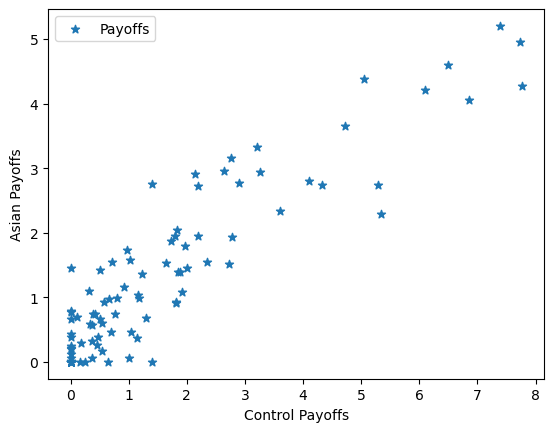

0.916153689517822
Control variate price estimate
1.3292114854637487
Variance ratio of payoffs (varAsianPayoff/Var(Y))
6.2242310151583204


In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Inputs
n = 100
T = 2
M = 5
sigma = 0.25
k = 5
r = 0.04
S0 = 6

# Simulation of GBM
Z = np.random.normal(0, 1, size=(n, M))
S = np.exp(
    np.cumsum((r - 0.5 * (sigma ** 2)) * (T / M) + sigma * np.sqrt(T / M) * Z, axis=1)
    + np.log(S0)
)

# Option payoffs
Asian_Payoffs = np.exp(-r * T) * np.maximum(np.mean(S, axis=1) - k, 0)
Control_Payoffs = np.exp(-r * T) * np.maximum(S[:, -1] - k, 0)
print(Asian_Payoffs)

# Estimate prices by crude Monte Carlo
Asian_PriceEst = np.mean(Asian_Payoffs)
Control_PriceEst = np.mean(Control_Payoffs)
print(Asian_PriceEst)

# Price est using control variate
#print('CMC price estimate')
print(Asian_PriceEst)

# Plots payoffs to show correlation
plt.scatter(Control_Payoffs, Asian_Payoffs, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('Asian Payoffs')
plt.legend()
plt.show()

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (sigma * np.sqrt(T))) * (np.log(S0 / k) + (r + 0.5 * sigma ** 2) * T)
d2 = d1 - sigma * np.sqrt(T)
Control_Mean = norm.cdf(d1) * S0 - norm.cdf(d2) * k * np.exp(-r * T)

# Calculates Y_i's
covariance = np.cov([Asian_Payoffs, Control_Payoffs], ddof=0)
alfa = -covariance[0, 1] / covariance[1, 1]
Y = Asian_Payoffs + alfa * (Control_Payoffs - Control_Mean)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho = np.corrcoef(Asian_Payoffs, Control_Payoffs)[0, 1]
print(rho)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y))

# Checks variances
print('Variance ratio of payoffs (varAsianPayoff/Var(Y))')
var_ratio = np.var(Asian_Payoffs) / np.var(Y)
print(var_ratio)


# Thor adjusted for American (be OPS on the Python environment - variables might not update, so run code twice).

0.2653087662204202
0.40021114435443716
10000 10000


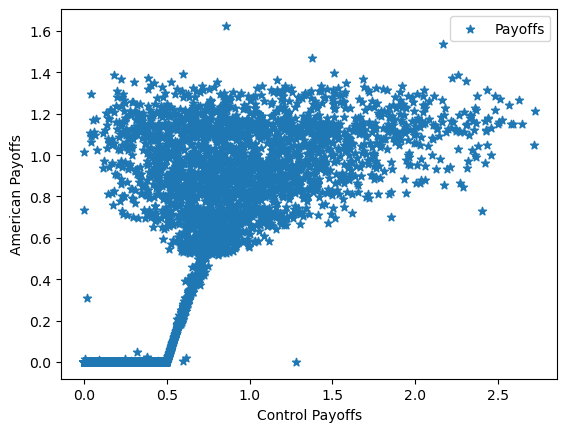

Correlation coeff
0.8038501645672047
Control variate price estimate
1.1986810068041598
Variance ratio of payoffs (varVanilla/VarControlVariate)
2.8262566130022475


In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Inputs
n = 10000
dim = n
T = 2
M = 5
sigma = 0.25
σ = sigma
k = 5
K = k
r = 0.04
S0 = 6


S_final = mc_pricer.S[:, -1]  # This should be the correct way to get S_final

# Create an instance of the class
mc_pricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed, use_AV)

# Simulation of GBM
mc_pricer.GeometricBrownianMotion_vec()  



# Option payoffs
_, _ = mc_pricer.american_option_LSM(poly_degree, otype='put')
American_Payoffs = mc_pricer.V
Control_Payoffs = np.array([mc_pricer.BS_option_value(Si, k, r, sigma, T, otype='put') for Si in S_final])
#print(American_Payoffs)
#print(Control_Payoffs)

# Estimate prices by crude Monte Carlo
American_price = np.mean(mc_pricer.V)
Control_PriceEst = np.mean(Control_Payoffs)
print(American_price)
print(Control_PriceEst)

#Check lenghts
print(len(American_Payoffs), len(Control_Payoffs))  # Both should be equal to n


# Plots payoffs to show correlation
plt.scatter(Control_Payoffs, American_Payoffs, marker='*', label='Payoffs')
plt.xlabel('Control Payoffs')
plt.ylabel('American Payoffs')
plt.legend()
plt.show()

# Control mean (Calculated using Black-Scholes)
d1 = (1 / (sigma * np.sqrt(T))) * (np.log(S0 / k) + (r + 0.5 * sigma ** 2) * T)
d2 = d1 - sigma * np.sqrt(T)
Control_Mean = norm.cdf(d1) * S0 - norm.cdf(d2) * k * np.exp(-r * T)

# Calculates Y_i's
covariance = np.cov([American_Payoffs, Control_Payoffs], ddof=0)
alfa = -covariance[0, 1] / covariance[1, 1]
Y = American_Payoffs + alfa * (Control_Payoffs - Control_Mean)

# Prints correlation coefficient
#print('Correlation of payoffs')
rho = np.corrcoef(American_Payoffs, Control_Payoffs)[0, 1]
print('Correlation coeff')

print(rho)

# Price est using control variate
print('Control variate price estimate')
print(np.mean(Y))

# Checks variances
print('Variance ratio of payoffs (varVanilla/VarControlVariate)')
var_ratio = np.var(American_Payoffs) / np.var(Y)
print(var_ratio)



In [71]:
# Initialize parameters
r = 0.03
S0 = 100
K = 100
T = 1
σ = 0.25
dim = 100000
n = 252
seed = 42
use_AV = False
poly_degree = 3

# Create an instance of the class
mc_pricer = MonteCarloOptionPricing(r, S0, K, T, σ, dim, n, seed, use_AV)

# Generate stock price paths
mc_pricer.GeometricBrownianMotion_vec()  # or mc_pricer.GeometricBrownianMotion()

# Run the LSM method
_, _ = mc_pricer.american_option_LSM(poly_degree, otype='put')

# Access the V matrix
V_matrix = mc_pricer.V
#print(V_matrix)

prisen = np.average(mc_pricer.V)
print(prisen)

8.627613610192375


In [8]:
# Calculate the variances
variance_original = np.var(Asian_Payoffs)
variance_with_control_variate = np.var(Y)

# Calculate the variance reduction ratio
variance_reduction_ratio = (variance_original - variance_with_control_variate) / variance_original

# Print the result
print('Variance reduction ratio:', variance_reduction_ratio)

Variance reduction ratio: 0.7997137478959782


## American options using European call as Control Variate

In [18]:

# Define the option parameters
# Inputs
n = 10000
T = 2
M = 5
sigma = 0.25
k = 5
r = 0.04
S0 = 6

# Create an instance of MonteCarloOptionPricing for the American option
option = MonteCarloOptionPricing(r, S0, K, T, sigma, n, M, seed, use_AV=False)  # Set use_AV as needed

# Simulate the stock price paths for the American option
option.GeometricBrownianMotion_vec()

# Calculate the American option payoff using the LSM method
American_PriceEst, exercise_times = option.american_option_LSM(poly_degree=2, otype='put')
Control_Payoffs_EU = np.exp(-r * T) * np.maximum(S[:, -1] - k, 0)

# Price est using control variate (European option as control)
#print('CMC price estimate')
#print(American_PriceEst)

# Plots payoffs to show correlation
Control_Payoffs = np.exp(-r * T) * np.maximum(option.S[:, -1] - K, 0)  # European option payoff as control
#plt.scatter(Control_Payoffs, American_PriceEst, marker='*', label='Payoffs')
#plt.xlabel('Control Payoffs')
#plt.ylabel('American Payoffs')
#plt.legend()
#plt.show()

# Prints correlation coefficient
#print('Correlation of payoffs')
rho = np.corrcoef(Asian_Payoffs, Control_Payoffs)[0, 1]
print(rho)

# Checks variances
print('Variance ratio of payoffs (varControlPayoff/Var(AmericanPayoff))')
var_ratio = np.var(Control_Payoffs) / np.var(American_PriceEst)
print(var_ratio)


-0.01846365495176308
Variance ratio of payoffs (varControlPayoff/Var(AmericanPayoff))
inf


C:\Users\user\AppData\Local\Temp\ipykernel_12360\2961158624.py:40: RuntimeWarning: divide by zero encountered in double_scalars
  var_ratio = np.var(Control_Payoffs) / np.var(American_PriceEst)
